In [1]:
import sys
import rospy
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sensor_msgs.msg import Image
from cv_bridge import CvBridge
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
rgbimg = cv2.imread('rgb.jpg')
rgbimg = cv2.cvtColor(rgbimg, cv2.COLOR_RGB2BGR)
depthimg = cv2.imread('depth.jpg',0)

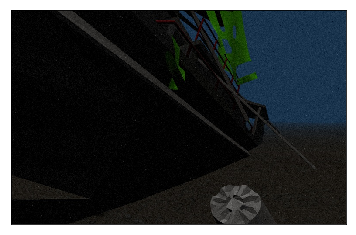

In [3]:
plt.imshow(rgbimg)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

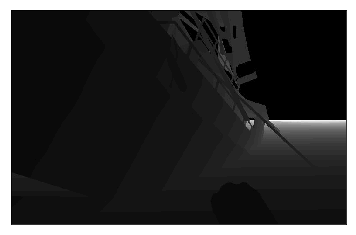

In [4]:
plt.imshow(depthimg, cmap = 'gray')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

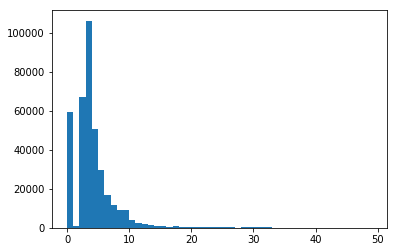

In [5]:
plt.hist(depthimg.ravel(),np.amax(depthimg),[0,np.amax(depthimg)]); plt.show()

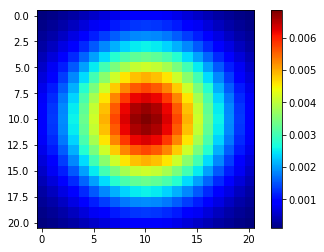

In [14]:
# http://subsurfwiki.org/wiki/Gaussian_filter
def gaussian_kernel(size = 10, size_y=None, sigma = 6):
    size = int(size/2)
    if not size_y:
        size_y = size
    else:
        size_y = int(size_y)
    x, y = np.mgrid[-size:size+1, -size_y:size_y+1]
    g = np.exp(-(x**2/float(2*sigma**2)+y**2/float(2*sigma**2)))
    return g / g.sum()
 
# Make the Gaussian by calling the function
gaussian_kernel_array = gaussian_kernel(size = 20, sigma = 5)
 
plt.imshow(gaussian_kernel_array, cmap=plt.get_cmap('jet'), interpolation='nearest')
plt.colorbar()
plt.show()

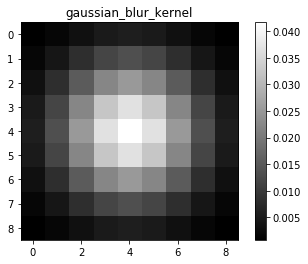

In [7]:
# https://nbviewer.jupyter.org/github/mroberts3000/GpuComputing/blob/master/IPython/GaussianBlur.ipynb
import scipy

gaussian_blur_kernel_width      = np.int32(9)
gaussian_blur_kernel_half_width = np.int32(4)
gaussian_blur_sigma             = np.float32(2)

y, x = \
    scipy.mgrid[-gaussian_blur_kernel_half_width:gaussian_blur_kernel_half_width+1,
                -gaussian_blur_kernel_half_width:gaussian_blur_kernel_half_width+1]

gaussian_blur_kernel_not_normalized = np.exp( ( - ( x**2 + y**2 ) ) / ( 2 * gaussian_blur_sigma**2 ) )
normalization_constant              = np.float32(1) / np.sum(gaussian_blur_kernel_not_normalized)
gaussian_blur_kernel                = (normalization_constant * gaussian_blur_kernel_not_normalized).astype(np.float32)



plt.imshow(gaussian_blur_kernel, cmap="gray", interpolation="nearest");
plt.title("gaussian_blur_kernel");
plt.colorbar();

In [8]:
# import the necessary packages
#import imutils

def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [142]:
# define the window width and height
clone = rgbimg.copy()
gauss_image = np.zeros((rgbimg.shape[0],rgbimg.shape[1]), np.float32)
(winW, winH) = (101, 101)
print(np.amax(depthimg))

for (x, y, window) in sliding_window(clone, stepSize=101, windowSize=(winW, winH)):
	# if the window does not meet our desired window size, ignore it
	if window.shape[0] != winH or window.shape[1] != winW:
		continue

	sig = np.mean(depthimg[y:y + winW, x:x + winH])+1
    
	
	#clone[y:y + winW, x:x + winH] = cv2.GaussianBlur(window,(winW, winH), int(sig))
	kernel = gaussian_kernel(size = winW, sigma = sig)
	gauss_image[y:y + winW, x:x + winH] = gauss_image[y:y + winW, x:x + winH] + kernel
	clone[y:y + winW, x:x + winH] = cv2.filter2D(clone[y:y + winW, x:x + winH],-1,kernel)
	

	# since we do not have a classifier, we'll just draw the window
	#clone = rgbimg.copy()
	#cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
	#cv2.imshow("Window", clone)
	#cv2.waitKey(1)

49


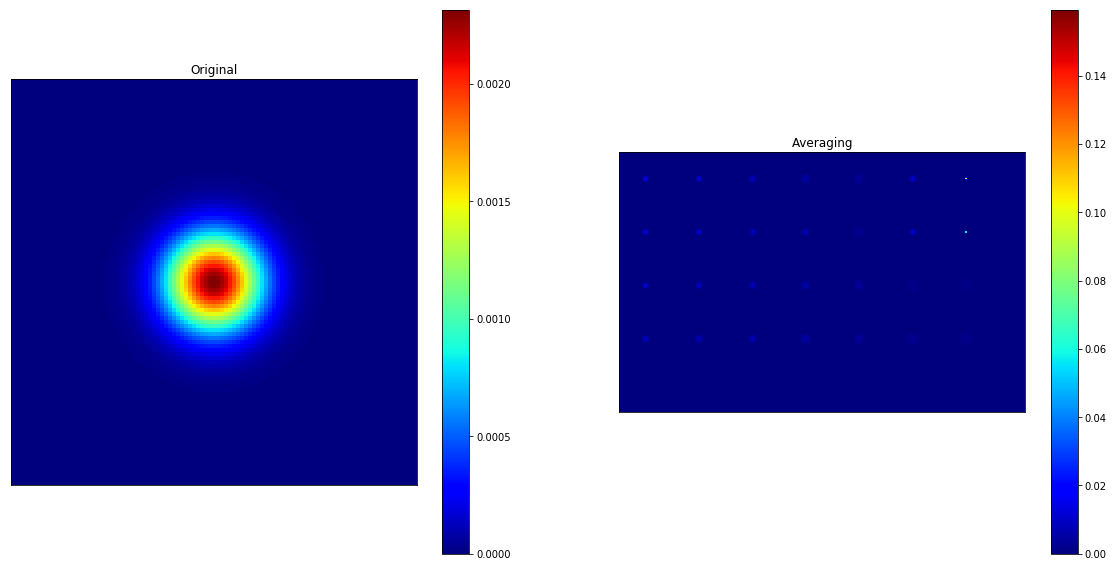

In [143]:
plt.subplot(121),plt.imshow(kernel, cmap=plt.get_cmap('jet'), interpolation='nearest'),plt.title('Original')
plt.xticks([]), plt.yticks([]),plt.colorbar()
plt.subplot(122),plt.imshow(gauss_image, cmap=plt.get_cmap('jet'), interpolation='nearest'),plt.title('Averaging')
plt.xticks([]), plt.yticks([]),plt.colorbar()
plt.show()

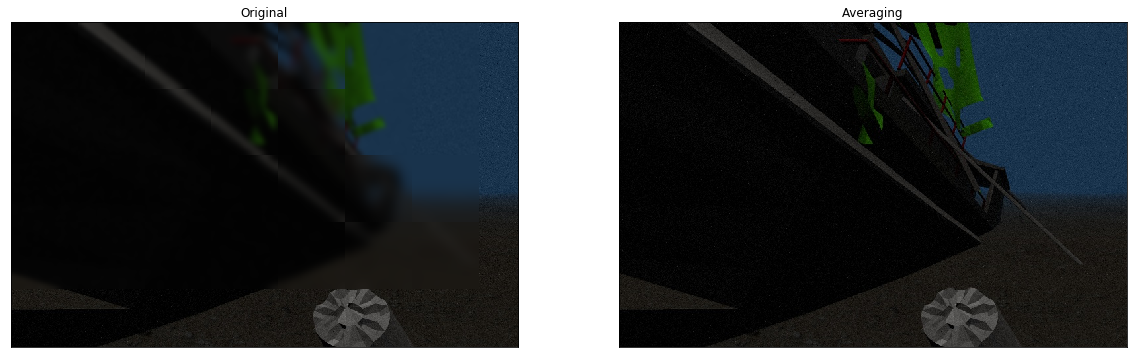

In [144]:
#clone = rgbimg.copy()
#dst = cv2.filter2D(clone,-1,gauss_image)
plt.subplot(121),plt.imshow(clone),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(rgbimg),plt.title('Averaging')
plt.xticks([]), plt.yticks([])
plt.show()